In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from pathlib import Path

mnt_path = "/conte/drive/"

Path(mnt_path).glob("*/UJ/")

<generator object Path.glob at 0x7f9f473e48e0>

In [ ]:
!ls /content/drive/My\ Drive/UJ/NLP/project

working_dir = r"/content/drive/My Drive/UJ/NLP/project/"


 dev.txt  'Files description.gdoc'   test.txt   train.txt   word_vectors.txt


In [ ]:
import pandas as pd

files = ["train.txt", "test.txt", "dev.txt"]

d = [pd.read_csv( working_dir + x,sep="\t") for x in files ]
d = pd.concat(d)[["gold_label", "sentence1", "sentence2"]]
not_interesting = d[ d.gold_label == '-']
d = d[ d.gold_label != '-']

letsDoSth = pd.read_csv( working_dir + "train.txt",sep="\t")
newD = letsDoSth[ letsDoSth.gold_label != '-'][["gold_label", "sentence1", "sentence2"]]

validData = pd.read_csv(working_dir + "dev.txt", sep="\t")
validData = validData[validData.gold_label != '-'][["gold_label", "sentence1", "sentence2"]]

testData = pd.read_csv(working_dir + "test.txt", sep="\t")
testData = testData[testData.gold_label != '-'][["gold_label", "sentence1", "sentence2"]]


# 10 sentences that were removed


In [ ]:
pd.set_option('display.max_colwidth', -1)
not_interesting[[ "sentence1", "sentence2"]].head()

,sentence1,sentence2
156,A woman wearing a pink hat is looking at a pink car with the truck open.,The woman is wearing clothes.
518,A man in a white jacket standing in front of an older woman in a white jacket playing crochet.,The man was playing crochet with the two women.
1250,A man with red earphones is working on a red and white painted hot rod from Team ACE Racing.,A man in earphones is fixing a broken hotrod.
2082,A boy and a girl are walking in a mall.,A girl and a boy walking inside
2186,A man with sunglasses on his head is standing by signs for the Wharf and ferry terminal.,A guy and his pets are waiting by the terminal.


In [ ]:
from gensim.models import KeyedVectors
# from semantic_tests import semantic_tests
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile

glove_file = datapath(working_dir + 'word_vectors.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

model = KeyedVectors.load_word2vec_format(tmp_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Calculate set of words used in all files

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
nltk.download('punkt')


data =  { x.lower() for y in list(map(word_tokenize,d[["sentence1", "sentence2"]].to_numpy().ravel())) for x in y }

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#number of unique words


In [ ]:
len (data)

23759

## Create embedding


In [ ]:
listOfAllWords = list(data)
listOfAllWords = ["<bos>", "<pad>", "<eos>"] + listOfAllWords 
encoding = np.zeros((len(listOfAllWords) + 3, 200))

unk = np.random.randn(200)
bos = np.ones(200) * (-1.)



for x, word in enumerate (listOfAllWords):
  try:
    encoding[x] = model[word]
  except:
    encoding[x] = unk

bosTokenIndex = 0
padTokenIndex = 1
eosTokenIndex = 2

encoding[bosTokenIndex] = np.ones(200) * (-1.)
encoding[padTokenIndex] = np.zeros(200, dtype='float32')
encoding[eosTokenIndex] = np.ones(200)

listOfAllWords = {word : x for x, word in enumerate(listOfAllWords)}


In [ ]:
all(model['the'] ==  encoding[listOfAllWords['the']])

True

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt



embedding = nn.Embedding (len(encoding), 200)
embedding.load_state_dict({'weight': torch.from_numpy(encoding)})

<All keys matched successfully>

In [ ]:
def to_lowercase(words):
  new_words = []

  for word in words:
    new_words.append(word.lower())
  
  return new_words

def bake(words):
  out = np.ones(84, dtype ='int64')
  listT = [bosTokenIndex] + [ listOfAllWords[x] for x in words] + [eosTokenIndex]
  out[:len(listT)] = listT
  return out  

word_vectors = model.wv


def count_words(words):
  is_in_word_vectors = [ x in word_vectors for x in words]
  sum_of_words_in_word_vectors = sum(is_in_word_vectors)
  return np.array([ len(words) , len(words) - sum_of_words_in_word_vectors] )
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


In [ ]:
d['count_words'] = d.sentence1.apply(word_tokenize).apply(to_lowercase).apply(count_words)

In [ ]:
d[["sentence1", "count_words" ]].head(5)

,sentence1,count_words
0,Children smiling and waving at camera,"[6, 0]"
1,A boy is jumping on skateboard in the middle of a red bridge.,"[14, 0]"
2,Two blond women are hugging one another.,"[8, 0]"
3,An older man is drinking orange juice at a restaurant.,"[11, 0]"
4,"A man with blond-hair, and a brown shirt drinking out of a public water fountain.","[17, 1]"


In [ ]:
d.count_words.sum()

array([1838383,    4187])

In [ ]:
newD["sentence1tokenized"] = newD.sentence1.apply(word_tokenize).apply(to_lowercase).apply(bake)
newD["sentence2tokenized"] = newD.sentence2.apply(word_tokenize).apply(to_lowercase).apply(bake)
testData["sentence1tokenized"] = testData.sentence1.apply(word_tokenize).apply(to_lowercase).apply(bake)
testData["sentence2tokenized"] = testData.sentence2.apply(word_tokenize).apply(to_lowercase).apply(bake)
validData["sentence1tokenized"] = validData.sentence1.apply(word_tokenize).apply(to_lowercase).apply(bake)
validData["sentence2tokenized"] = validData.sentence2.apply(word_tokenize).apply(to_lowercase).apply(bake)

##Labels, One hot


In [ ]:
labels = {'neutral': 0, 'contradiction': 1, 'entailment': 2}

#Model


In [ ]:
class Encoder(nn.Module):
  def __init__(self, embedding, bathSize = 32):
      super(Encoder, self).__init__()
      self.bathSize = bathSize
      self.lstm = nn.LSTM(
            input_size=200,
            hidden_size=200,
            num_layers=1,
            bidirectional=False,
      )
      self.embedding = embedding


  def __listOfBorders(self, torchTensors):
    return torch.tensor ([(x == 2).nonzero()[0] + 1 for x in torchTensors] )

  def __toTorchTensors(self, __fromPundas):
      initS = torch.ones(self.bathSize, 84, dtype=torch.long)
      betwen = [torch.from_numpy(x) for x in __fromPundas.to_numpy()]
     
      for x, tok in enumerate (betwen):
        initS[x] = tok 

      return initS
    

  def forward(self, batched_tokens):
    temp = self.__toTorchTensors(batched_tokens)
    x = self.embedding(temp)
    x = nn.utils.rnn.pack_padded_sequence(x, self.__listOfBorders(temp), batch_first=True,  enforce_sorted=False)

    _outputs, (final_hidden, _final_cell) = self.lstm(x)
    return final_hidden[0]
    

In [ ]:
import torch.nn.functional as F

class FullyConnected(nn.Module):
  def __init__(self, bathSize = 32):
    super(FullyConnected, self).__init__()
    self.bathSize = bathSize
    self.layer1 = nn.Linear(400, 200)
    self.layer2 = nn.Linear(200,3)
    self.end = nn.Softmax(dim=1)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    return self.end(self.layer2(x))

def toOneHot(labelsT):
  labels = {'neutral': 0, 'contradiction': 1, 'entailment': 2}

  tensor = torch.zeros(len(labelsT), 3)
  for x, lab in enumerate(labelsT):
    tensor[x, labels[lab]] = 1

  return tensor
    

In [ ]:
class WholeCombined(nn.Module):
    def __init__(self, embedding, bathSize = 32):
      super(WholeCombined, self).__init__()
      self.encoderFirstSen = Encoder(embedding, bathSize=bathSize)
      self.encoderSecondSen = Encoder(embedding, bathSize=bathSize)
      self.fullyConnected = FullyConnected(bathSize=bathSize)


    def forward(self, x1, x2):
      nx1 = self.encoderFirstSen.forward(x1)
      nx2 = self.encoderSecondSen.forward(x2)

      return self.fullyConnected(torch.cat((nx1, nx2), dim=1))



In [ ]:
def test_accuracy(model, model_bath_size, data_set_to_test):
  x_begin = 0

  it = 0
  finalResult = 0

  for x in range(model_bath_size, len(data_set_to_test), model_bath_size ):
    it += 1
    testujemy = torch.argmax(model.forward(data_set_to_test.iloc[x_begin:x].sentence1tokenized, data_set_to_test.iloc[x_begin:x].sentence2tokenized) , dim=1).tolist()
    result = sum( [a == b  for a, b in zip(testujemy, [labels[a] for a in data_set_to_test.gold_label.iloc[x_begin:x].to_list()])] )
    
    finalResult += result
    x_begin = x

  return finalResult / (it * model_bath_size) * 100 


#Function that saves weights


In [ ]:
def save_weights(model, accuracy):
  PATH = ('net_accuracy_%.2f.pth' % (accuracy) ).replace( '.', '_', 1)
  torch.save(model.state_dict(), PATH)

#Function that loads weights


In [ ]:
def load_weights(PATH, bath_size=32):
  net = WholeCombined(embedding, bathSize=bath_size)
  net.load_state_dict(torch.load(PATH))
  return net


In [ ]:
import torch.optim as optim


model_bath_size = 64
att = WholeCombined(embedding, bathSize=model_bath_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(att.parameters() )

fA = FullyConnected()

accuracy of current epoch :  65.26756535947712


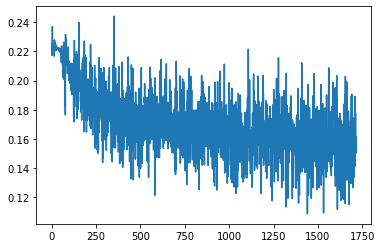

epoch finished 0
accuracy of current epoch :  68.72957516339869


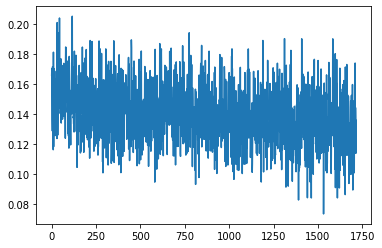

epoch finished 1


In [ ]:
import matplotlib.pyplot as plt


for y in range(2):
  x_begin = 0
  losses = []

  for x in range(model_bath_size, len(newD), model_bath_size ):
  

    optimizer.zero_grad()
    working_part = newD.iloc[x_begin:x]
    outputs = att(working_part.sentence1tokenized, 
    working_part.sentence2tokenized )
    loss = criterion (outputs, toOneHot(working_part.gold_label.tolist()) )
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    x_begin = x
  accuracy = test_accuracy(att,model_bath_size, validData)
  print ("accuracy of current epoch : ", accuracy)
  save_weights(att, accuracy)
  plt.figure(y)
  plt.plot(losses)
  plt.show()
  print ( 'epoch finished', y )

In [ ]:
test_accuracy(att, model_bath_size, validData)

68.09640522875817

In [ ]:
newModel = load_weights('net_accuracy_68_73.pth',64)
test_accuracy(newModel, model_bath_size, testData)

68.72957516339869